In [1]:
!pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import layers

In [3]:
(img_train, _), (_, _) = keras.datasets.cifar100.load_data()


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [4]:
img_train.shape

(50000, 32, 32, 3)

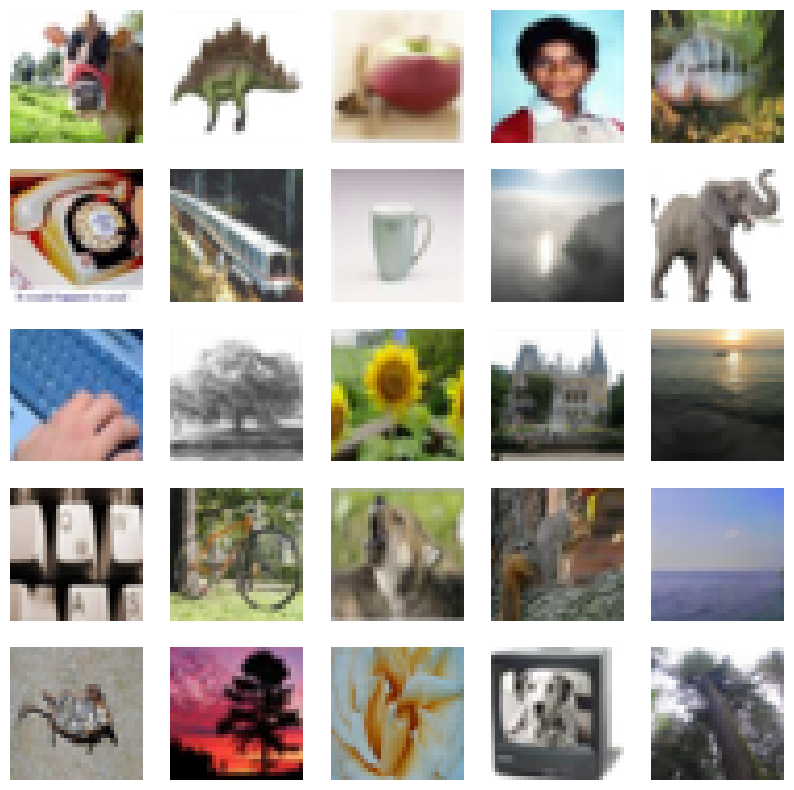

In [5]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(img_train[i])
  plt.axis("off")
plt.show()

In [6]:
img_train = img_train.reshape(img_train.shape[0], 32,32, 3 ).astype('float32')
img_train = (img_train - 127.5) / 127.5

In [7]:
img_train.shape

(50000, 32, 32, 3)

In [8]:
BUFFER_SIZE = 50000
BATCH_SIZE = 64

In [9]:
img_train

array([[[[ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.5294118 ,  0.60784316,  0.5137255 ],
         [ 0.6627451 ,  0.75686276,  0.6       ],
         [ 0.42745098,  0.52156866,  0.30980393]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 0.99215686,  0.99215686,  0.99215686],
         ...,
         [ 0.33333334,  0.38039216,  0.1764706 ],
         [ 0.2627451 ,  0.31764707,  0.01960784],
         [ 0.14509805,  0.20784314, -0.11372549]],

        [[ 1.        ,  1.        ,  1.        ],
         [ 0.99215686,  0.99215686,  0.99215686],
         [ 1.        ,  1.        ,  1.        ],
         ...,
         [ 0.48235294,  0.56078434,  0.3254902 ],
         [ 0.3019608 ,  0.39607844,  0.01960784],
         [-0.05098039,  0.04313726, -0.31764707]],

        ...,

        [[ 0.16078432,  0.4509804 , -0

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices(img_train).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
LATENT_DIM = 100
WEIGHT_UNIT = keras.initializers.RandomNormal(mean= 0.01, stddev=0.02)

In [12]:
def build_generator():
    model = keras.Sequential([
        layers.Dense(8*8*256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False, kernel_initializer=WEIGHT_UNIT),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False, kernel_initializer=WEIGHT_UNIT),
        layers.BatchNormalization(),
        layers.LeakyReLU(0.2),

        layers.Conv2DTranspose(3, (5,5), strides=(1,1), padding='same', use_bias=False, activation='tanh') # Output in [-1, 1]
    ])
    return model

generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
def build_discriminator():
    model = keras.Sequential([
        layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[32,32,3]),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5,5), strides=(2,2), padding='same'),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

discriminator = build_discriminator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
cross_entropy = keras.losses.BinaryCrossentropy()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) * 0.9, real_output)  # Label smoothing
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



In [15]:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

In [16]:
# GAN Class
class GAN(keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_optimizer, d_optimizer, g_loss, d_loss):
        super(GAN, self).compile()
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as d_tape:
            generated_images = self.generator(noise, training=True)
            real_output = self.discriminator(real_images, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            d_loss = self.d_loss(real_output, fake_output)

        d_gradients = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
        self.d_optimizer.apply_gradients(zip(d_gradients, self.discriminator.trainable_variables))

        noise = tf.random.normal([batch_size, LATENT_DIM])
        with tf.GradientTape() as g_tape:
            generated_images = self.generator(noise, training=True)
            fake_output = self.discriminator(generated_images, training=True)
            g_loss = self.g_loss(fake_output)

        g_gradients = g_tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(g_gradients, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_loss": g_loss}


In [17]:
 #Callback to visualize generated images
class ImageCallback(keras.callbacks.Callback):
    def __init__(self, num_images=16, latent_dim=100):
        self.num_images = num_images
        self.latent_dim = latent_dim
        self.seed = tf.random.normal([num_images, latent_dim])

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:
            generated_images = self.model.generator(self.seed, training=False)
            generated_images = (generated_images * 127.5) + 127.5

            plt.figure(figsize=(10,10))
            for i in range(self.num_images):
                plt.subplot(4, 4, i+1)
                plt.imshow(generated_images[i].numpy().astype("uint8"))
                plt.axis("off")
            plt.show()

In [18]:
EPOCH = 100

In [19]:

gan = GAN(generator=generator, discriminator=discriminator)
gan.compile(
    g_optimizer=generator_optimizer,
    d_optimizer=discriminator_optimizer,
    g_loss=generator_loss,
    d_loss=discriminator_loss
)

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - d_loss: 1.2065 - g_loss: 1.2287

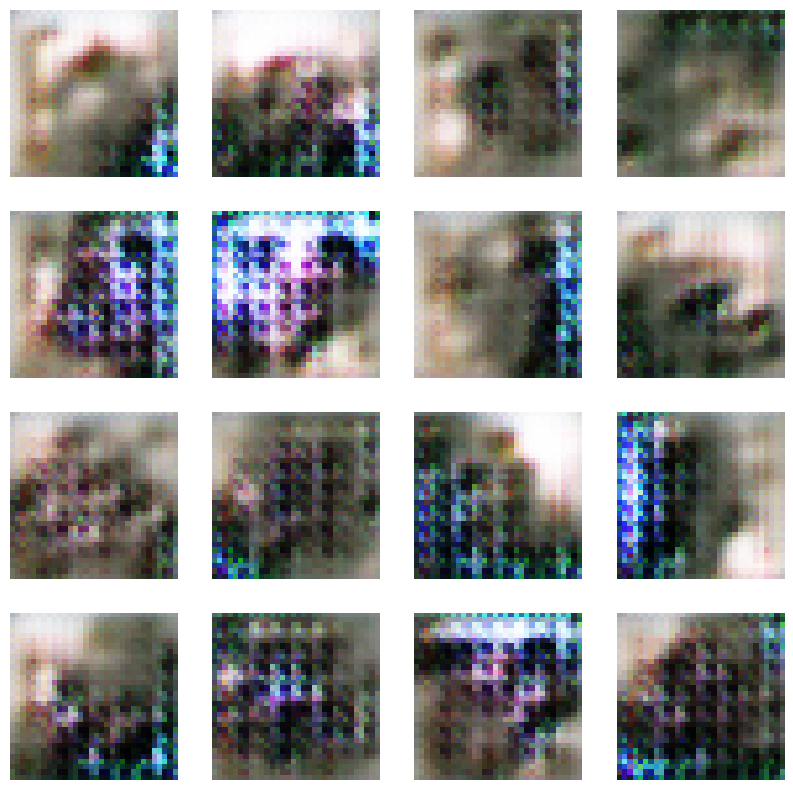

782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 41ms/step - d_loss: 1.2066 - g_loss: 1.2285
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 25s 31ms/step - d_loss: 1.3156 - g_loss: 0.9848
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - d_loss: 1.3102 - g_loss: 0.9708
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - d_loss: 1.3119 - g_loss: 0.9439
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - d_loss: 1.3108 - g_loss: 0.9707
Epoch 6/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3079 - g_loss: 0.9866

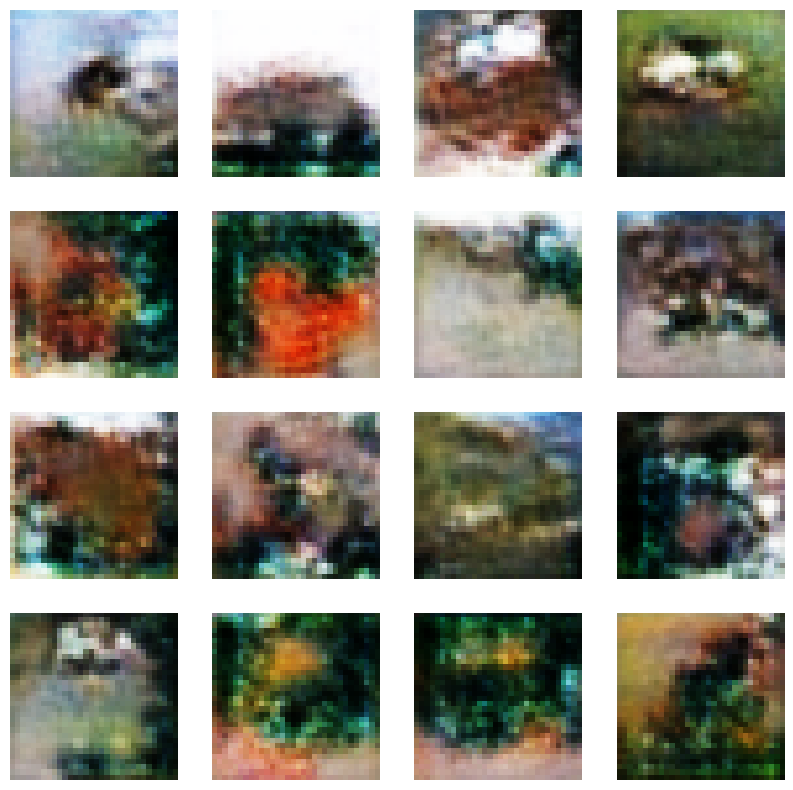

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3079 - g_loss: 0.9871
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3139 - g_loss: 0.9594
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3179 - g_loss: 0.9329
Epoch 9/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3245 - g_loss: 0.9262
Epoch 10/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3228 - g_loss: 0.9243
Epoch 11/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3314 - g_loss: 0.9196

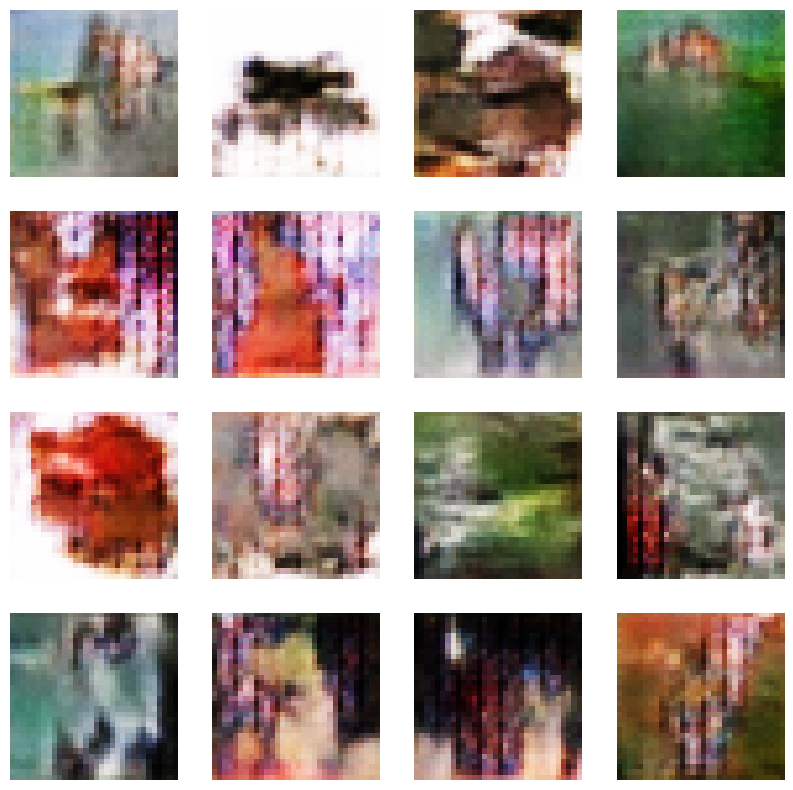

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3317 - g_loss: 0.9198
Epoch 12/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 34ms/step - d_loss: 1.3420 - g_loss: 0.9013
Epoch 13/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - d_loss: 1.3435 - g_loss: 0.8937
Epoch 14/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3508 - g_loss: 0.8873
Epoch 15/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3518 - g_loss: 0.8758
Epoch 16/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3552 - g_loss: 0.8757

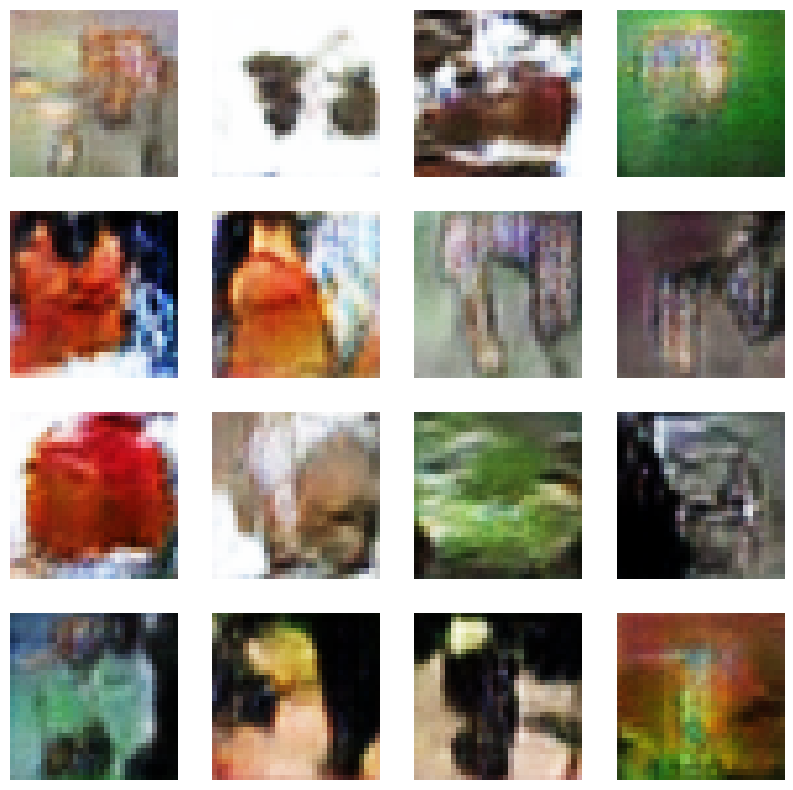

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3553 - g_loss: 0.8755
Epoch 17/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3569 - g_loss: 0.8686
Epoch 18/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3580 - g_loss: 0.8677
Epoch 19/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3567 - g_loss: 0.8658
Epoch 20/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3579 - g_loss: 0.8626
Epoch 21/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3591 - g_loss: 0.8660

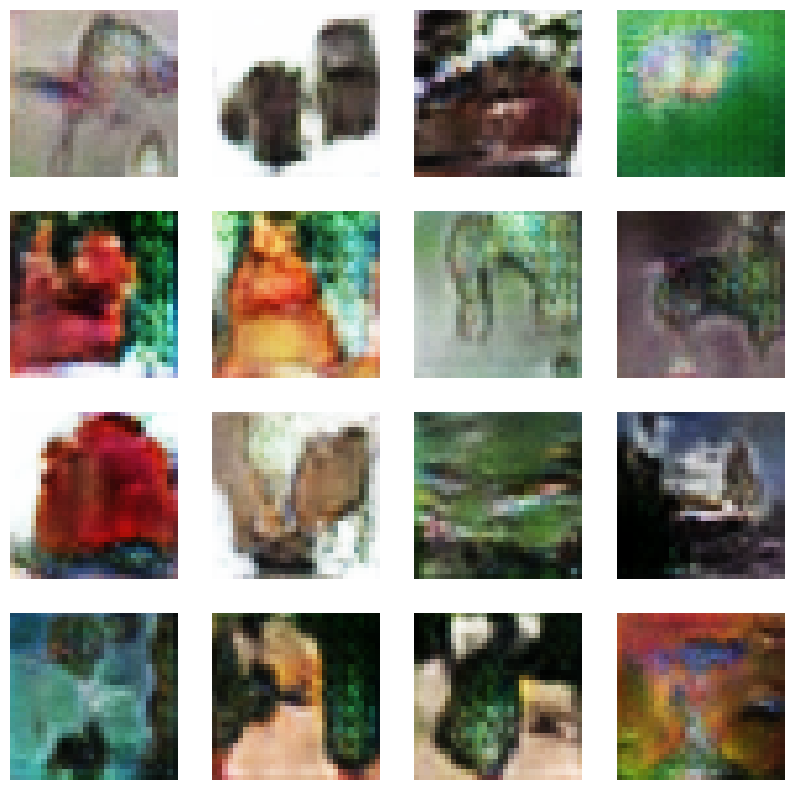

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3590 - g_loss: 0.8660
Epoch 22/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3580 - g_loss: 0.8614
Epoch 23/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3609 - g_loss: 0.8613
Epoch 24/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - d_loss: 1.3589 - g_loss: 0.8632
Epoch 25/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3578 - g_loss: 0.8582
Epoch 26/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3587 - g_loss: 0.8625

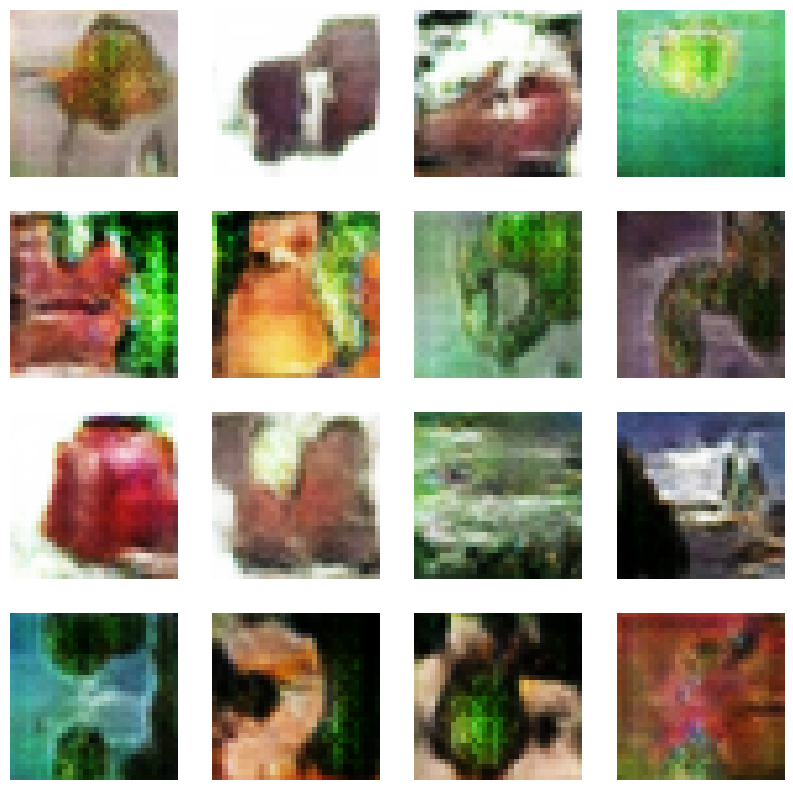

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3586 - g_loss: 0.8625
Epoch 27/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3567 - g_loss: 0.8609
Epoch 28/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3589 - g_loss: 0.8598
Epoch 29/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3583 - g_loss: 0.8653
Epoch 30/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3560 - g_loss: 0.8595
Epoch 31/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3575 - g_loss: 0.8670

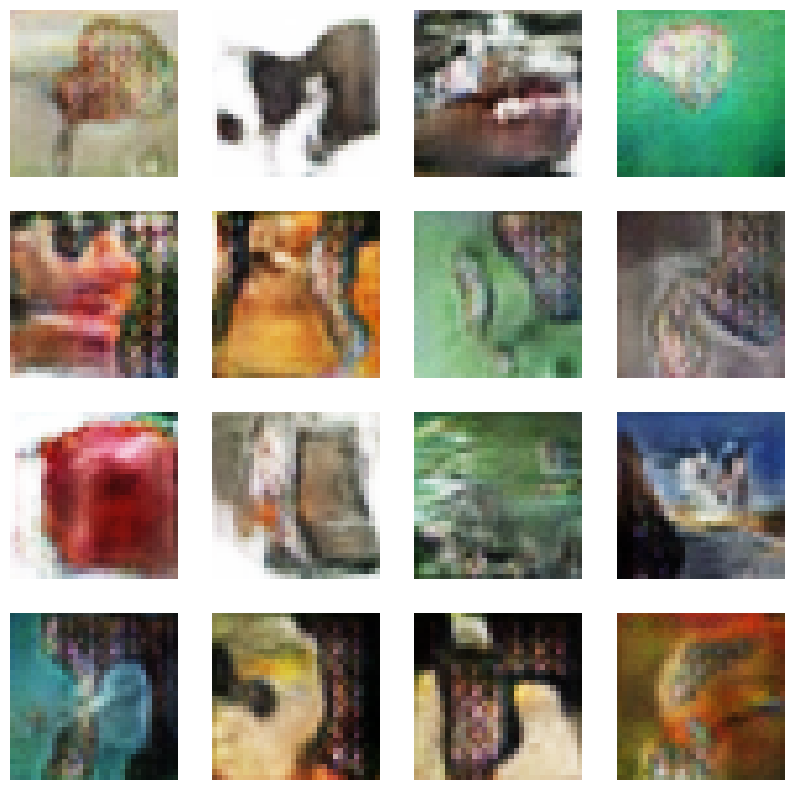

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3575 - g_loss: 0.8670
Epoch 32/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3583 - g_loss: 0.8624
Epoch 33/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3570 - g_loss: 0.8590
Epoch 34/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3589 - g_loss: 0.8641
Epoch 35/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3578 - g_loss: 0.8579
Epoch 36/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3581 - g_loss: 0.8603

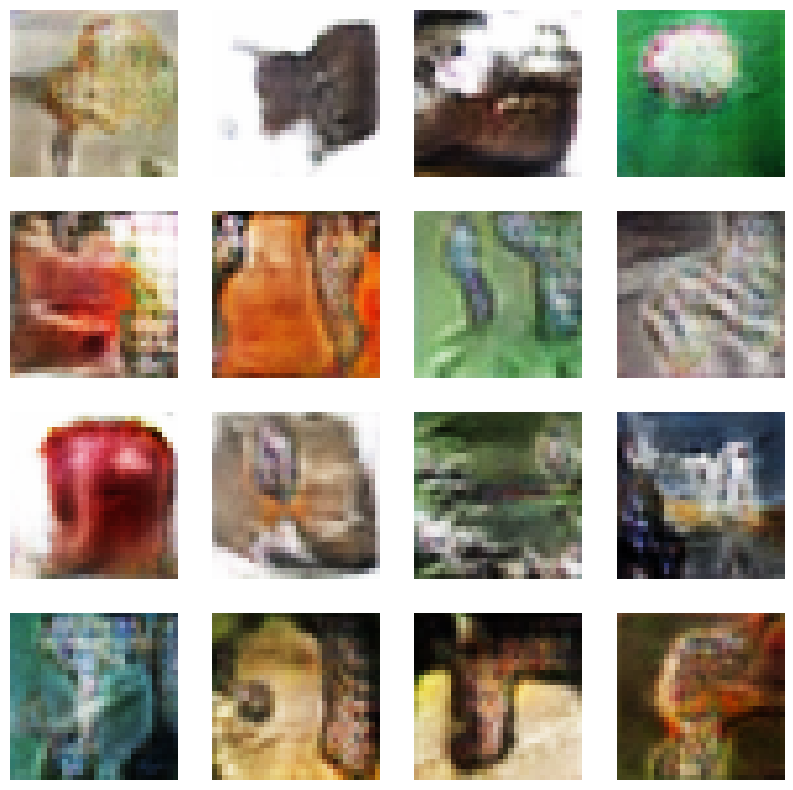

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3582 - g_loss: 0.8603
Epoch 37/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3585 - g_loss: 0.8609
Epoch 38/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3592 - g_loss: 0.8633
Epoch 39/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3595 - g_loss: 0.8584
Epoch 40/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3585 - g_loss: 0.8571
Epoch 41/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3580 - g_loss: 0.8579

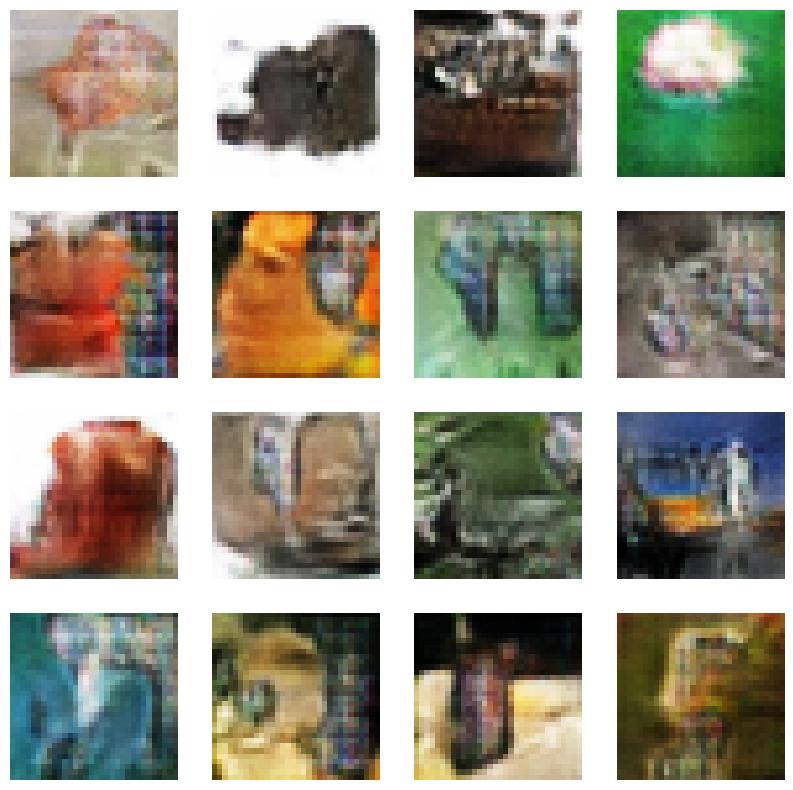

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3582 - g_loss: 0.8577
Epoch 42/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3607 - g_loss: 0.8571
Epoch 43/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3579 - g_loss: 0.8534
Epoch 44/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3595 - g_loss: 0.8579
Epoch 45/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3599 - g_loss: 0.8567
Epoch 46/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3581 - g_loss: 0.8527

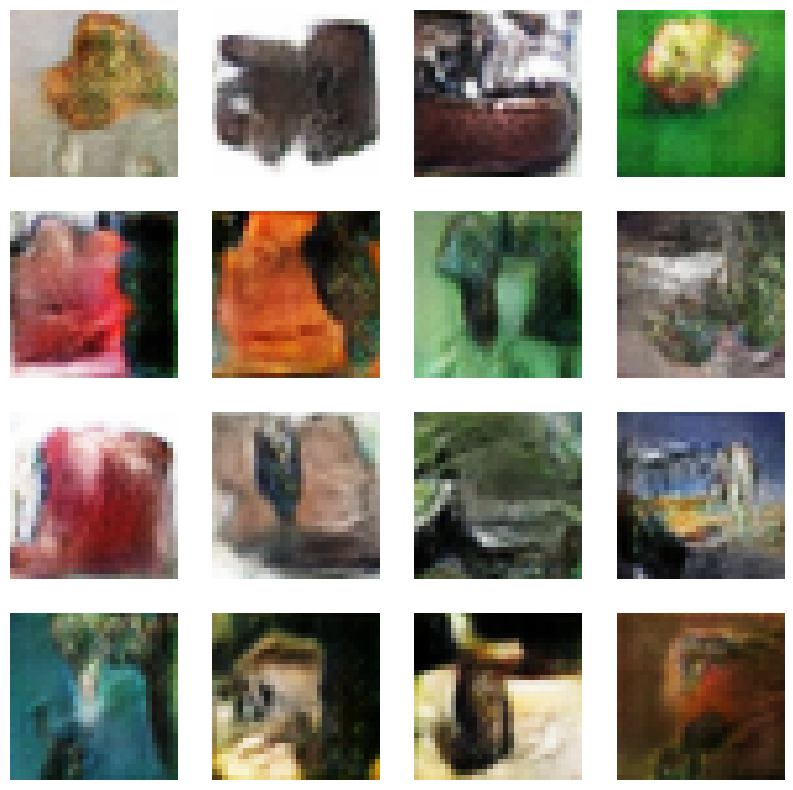

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3581 - g_loss: 0.8525
Epoch 47/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3600 - g_loss: 0.8569
Epoch 48/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3574 - g_loss: 0.8526
Epoch 49/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3610 - g_loss: 0.8548
Epoch 50/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3615 - g_loss: 0.8550
Epoch 51/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3611 - g_loss: 0.8552

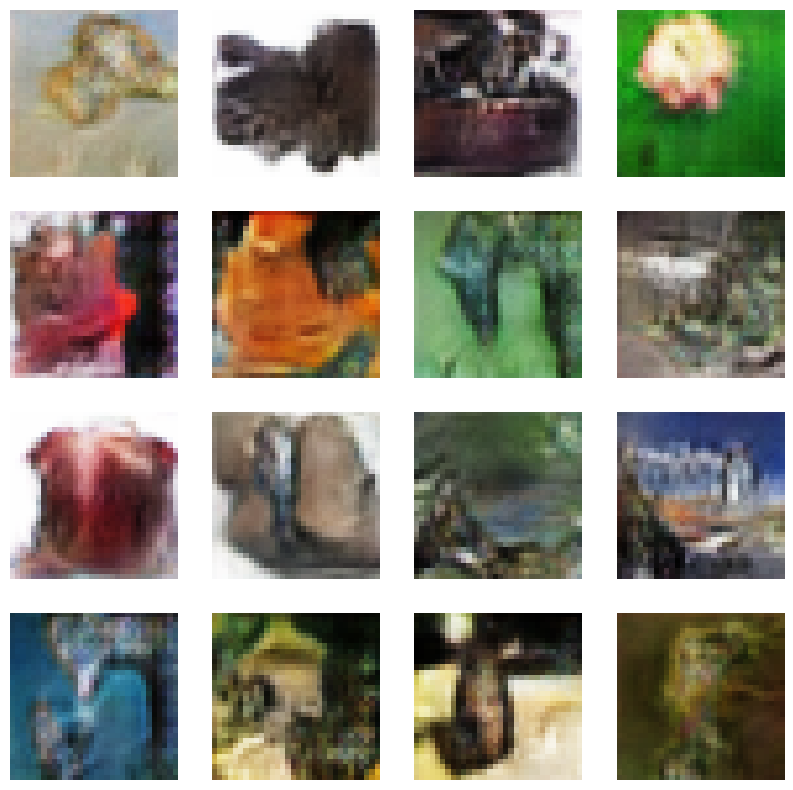

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3612 - g_loss: 0.8550
Epoch 52/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3611 - g_loss: 0.8526
Epoch 53/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3598 - g_loss: 0.8548
Epoch 54/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3604 - g_loss: 0.8535
Epoch 55/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3594 - g_loss: 0.8541
Epoch 56/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3597 - g_loss: 0.8549

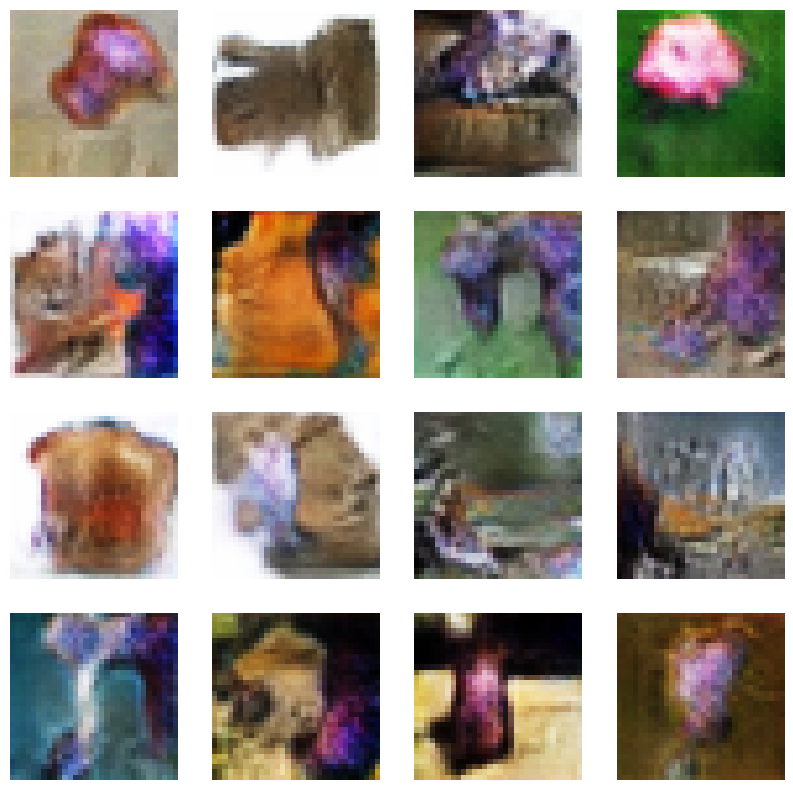

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3594 - g_loss: 0.8549
Epoch 57/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3580 - g_loss: 0.8561
Epoch 58/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3595 - g_loss: 0.8508
Epoch 59/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3597 - g_loss: 0.8565
Epoch 60/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3567 - g_loss: 0.8536
Epoch 61/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3583 - g_loss: 0.8573

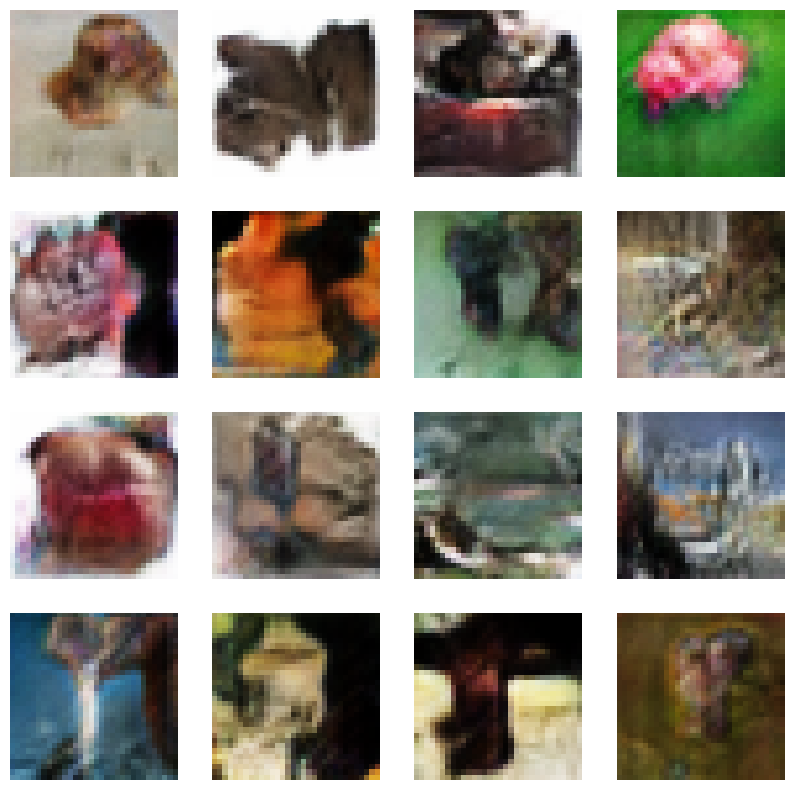

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3582 - g_loss: 0.8571
Epoch 62/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3582 - g_loss: 0.8537
Epoch 63/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3565 - g_loss: 0.8571
Epoch 64/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3585 - g_loss: 0.8581
Epoch 65/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3573 - g_loss: 0.8561
Epoch 66/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3569 - g_loss: 0.8579

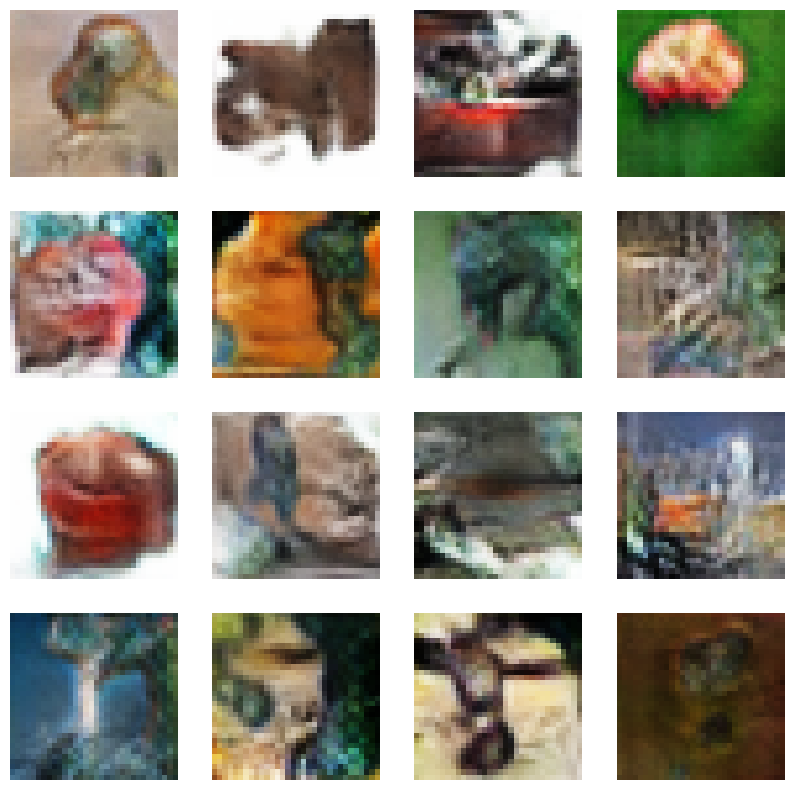

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - d_loss: 1.3569 - g_loss: 0.8578
Epoch 67/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3564 - g_loss: 0.8571
Epoch 68/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3556 - g_loss: 0.8584
Epoch 69/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3579 - g_loss: 0.8597
Epoch 70/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3575 - g_loss: 0.8564
Epoch 71/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3580 - g_loss: 0.8589

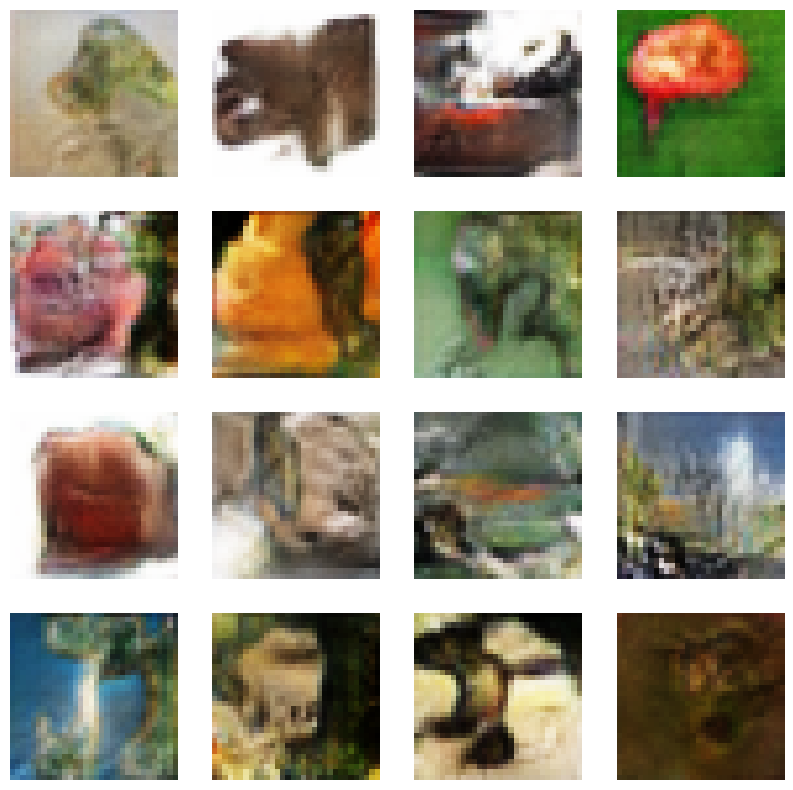

782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3579 - g_loss: 0.8587
Epoch 72/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3600 - g_loss: 0.8543
Epoch 73/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - d_loss: 1.3574 - g_loss: 0.8574
Epoch 74/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3577 - g_loss: 0.8529
Epoch 75/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3578 - g_loss: 0.8575
Epoch 76/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3584 - g_loss: 0.8542

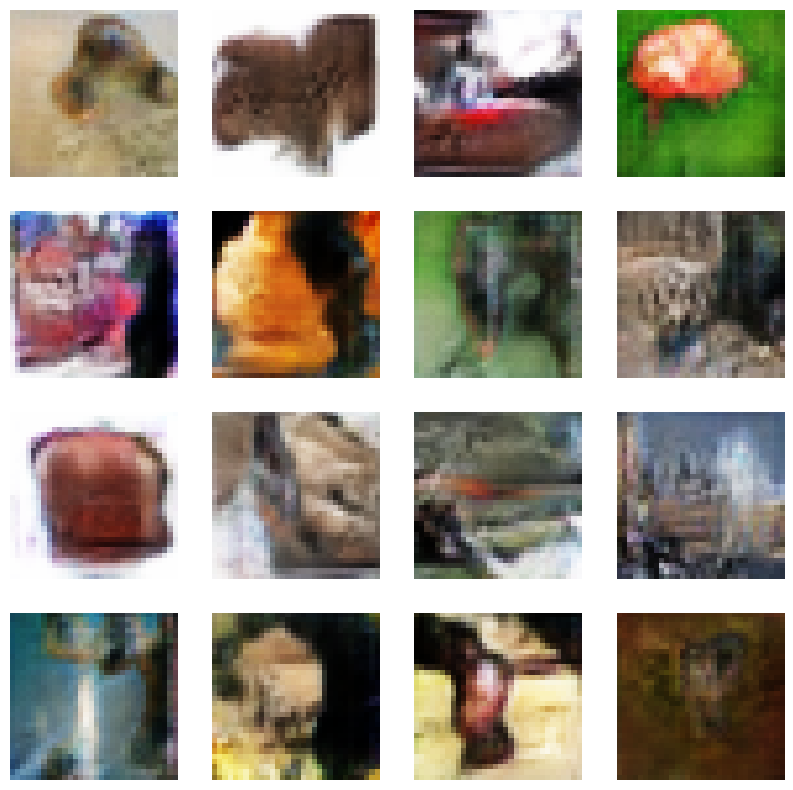

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3585 - g_loss: 0.8541
Epoch 77/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3558 - g_loss: 0.8555
Epoch 78/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3588 - g_loss: 0.8595
Epoch 79/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3557 - g_loss: 0.8556
Epoch 80/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3570 - g_loss: 0.8576
Epoch 81/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3560 - g_loss: 0.8582

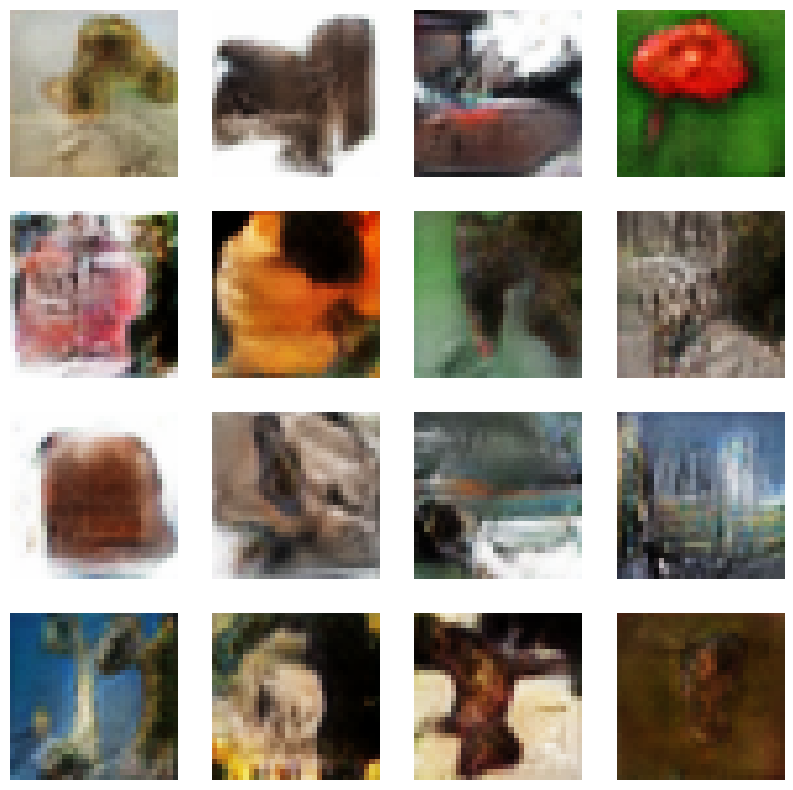

782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3559 - g_loss: 0.8582
Epoch 82/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 42s 35ms/step - d_loss: 1.3574 - g_loss: 0.8548
Epoch 83/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3570 - g_loss: 0.8612
Epoch 84/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3553 - g_loss: 0.8577
Epoch 85/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - d_loss: 1.3586 - g_loss: 0.8571
Epoch 86/100
780/782 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - d_loss: 1.3559 - g_loss: 0.8553

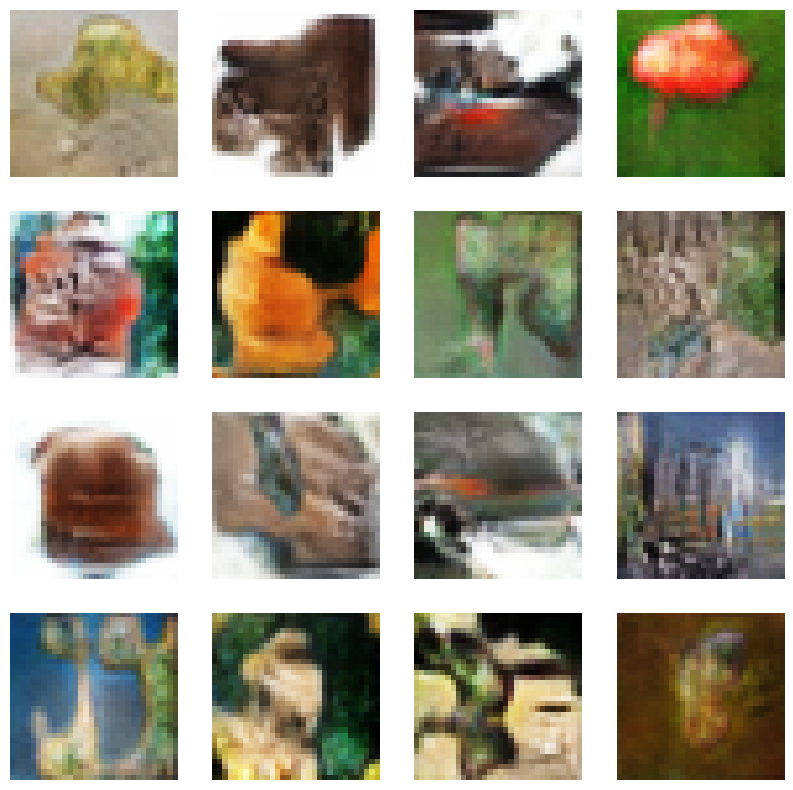

782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3560 - g_loss: 0.8554
Epoch 87/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3553 - g_loss: 0.8564
Epoch 88/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3568 - g_loss: 0.8599
Epoch 89/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - d_loss: 1.3562 - g_loss: 0.8579
Epoch 90/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 40s 34ms/step - d_loss: 1.3569 - g_loss: 0.8580
Epoch 91/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3564 - g_loss: 0.8556

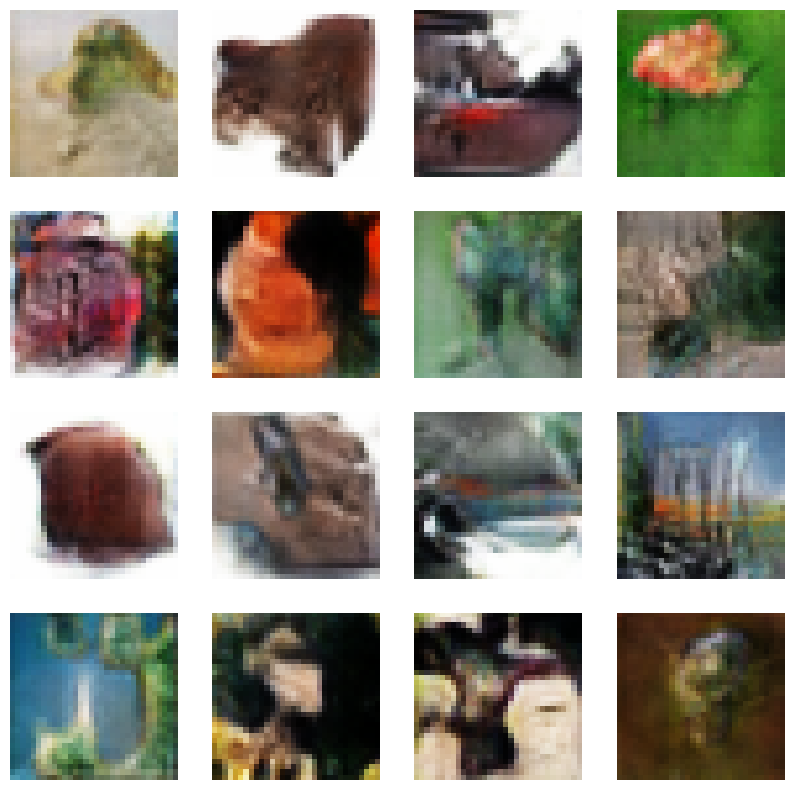

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - d_loss: 1.3563 - g_loss: 0.8556
Epoch 92/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3555 - g_loss: 0.8601
Epoch 93/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3564 - g_loss: 0.8555
Epoch 94/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3546 - g_loss: 0.8612
Epoch 95/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 34ms/step - d_loss: 1.3555 - g_loss: 0.8585
Epoch 96/100
781/782 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - d_loss: 1.3561 - g_loss: 0.8605

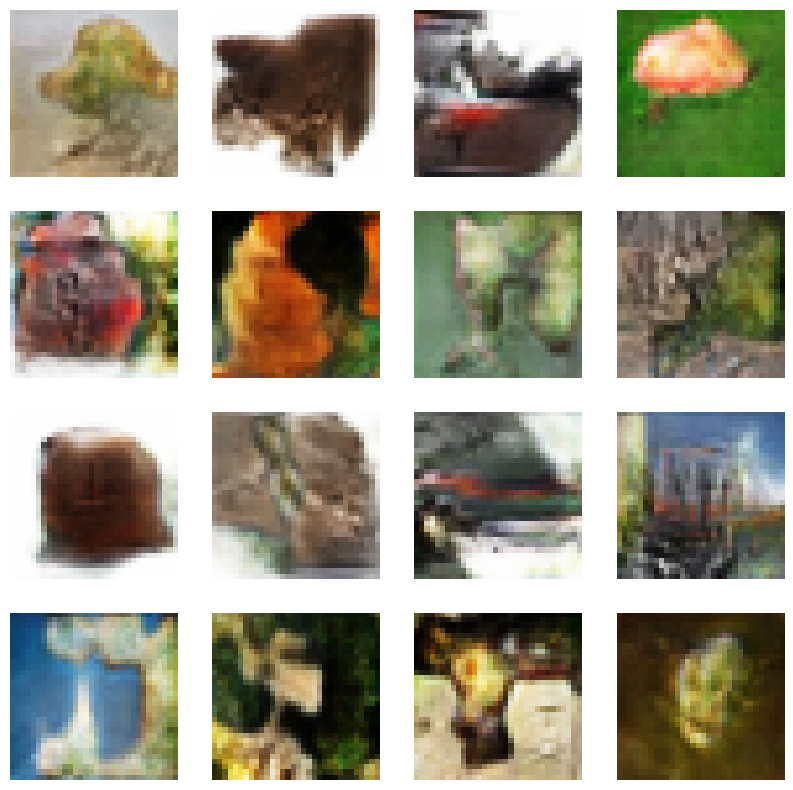

782/782 ━━━━━━━━━━━━━━━━━━━━ 28s 35ms/step - d_loss: 1.3562 - g_loss: 0.8605
Epoch 97/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3542 - g_loss: 0.8561
Epoch 98/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - d_loss: 1.3565 - g_loss: 0.8607
Epoch 99/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 35ms/step - d_loss: 1.3553 - g_loss: 0.8574
Epoch 100/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - d_loss: 1.3581 - g_loss: 0.8590


In [20]:
history = gan.fit(train_dataset, epochs=EPOCH, callbacks=[ImageCallback()])

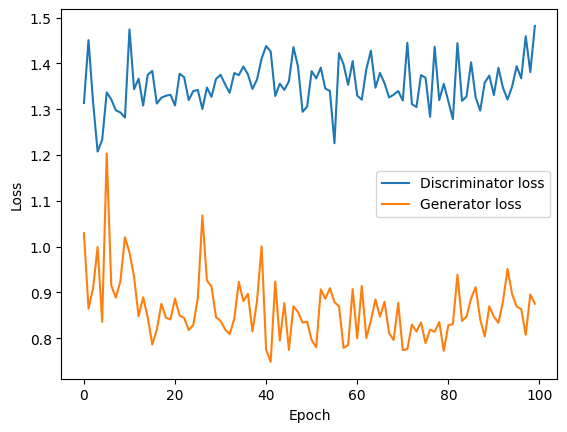

In [21]:
plt.plot(history.history['d_loss'], label='Discriminator loss')
plt.plot(history.history['g_loss'], label='Generator loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
# Test the generator
noise = tf.random.normal([25, LATENT_DIM])
generated_images = generator(noise)
generated_images = (generated_images * 127.5) + 127.5

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

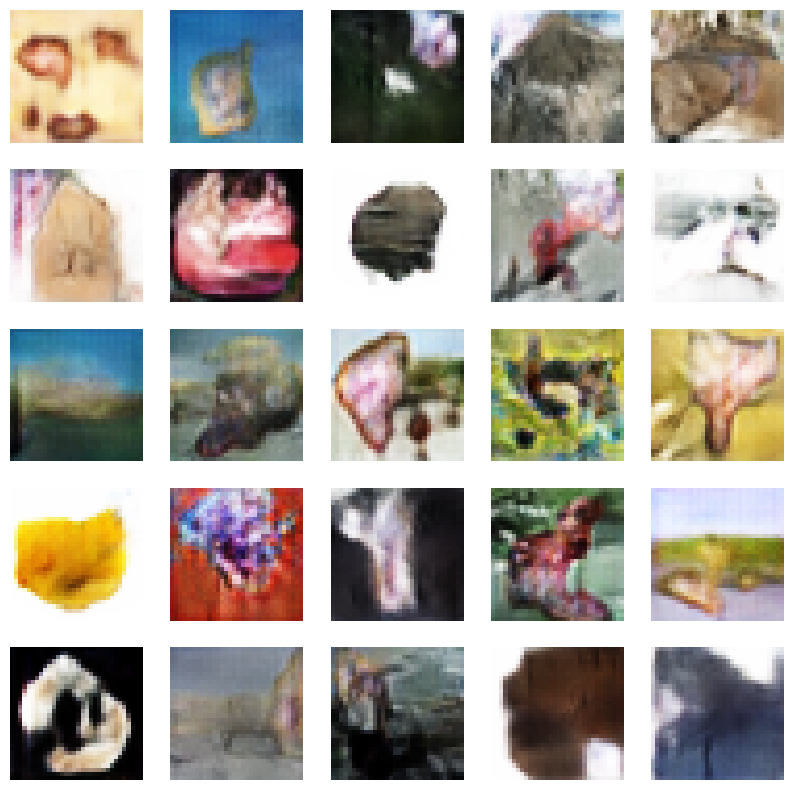

In [23]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  plt.imshow(generated_images[i].numpy().astype("uint8"), cmap="gray")
  plt.axis("off")
plt

In [24]:
generator.save("cifar_images.h5")

In [26]:
from google.colab import drive
drive.mount('g/drive')

ValueError: Mountpoint must be in a directory that exists

In [27]:
from google.colab import drive
drive.mount('/content/drive') # Change the mountpoint to /content/drive

Mounted at /content/drive


In [28]:
generator.save('/content/drive/MyDrive/cifar_images.h5')